<a href="https://colab.research.google.com/github/nilesh3030/Stroke-Prediction/blob/main/Notebooks/5_modelling_Random_Search_CV.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
pd.set_option ('display.max_columns', None)
pd.set_option ('display.max_rows', None)

In [36]:
## Data splitting and scaling
from sklearn.feature_selection import RFE
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
import lightgbm as lgb
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import RandomizedSearchCV
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
from sklearn.metrics import roc_auc_score, precision_score, recall_score, roc_curve, f1_score
from tqdm import tqdm
from sklearn.preprocessing import LabelEncoder
from sklearn.utils.class_weight import compute_class_weight
from xgboost import XGBClassifier

In [3]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [5]:
# !pip install mlflow
# import mlflow
# import mlflow.sklearn

In [4]:
model_data = pd.read_csv('/content/drive/MyDrive/Stroke_Prediction/Data/Modelling Data/model_data_2021_2022_with_weather_vars.csv')

In [5]:
model_data.columns

Index(['Unnamed: 0', 'cv_cc', 'cv2_cc', 'cv2_act', 'sex', 'stroke',
       'cv2_cphss', 'triage', 'onset', 'jaenan_sn', 'age', 'dbp1', 'sbp1',
       'pr1', 'rr1', 'bt1', 'spo2_1', 'dbp2', 'sbp2', 'pr2', 'rr2', 'bt2',
       'spo2_2', 'Month_x', 'Year_x', 'Spasm', 'Dizziness', 'Faint',
       'Consciousness', 'Paralysis', 'hy_di_disease', 'Disease_counts',
       'Branch_name', 'Temperature', 'Wind_Speed(m/s)', 'Precipitation(mm)',
       'Humidity(%)', 'Temp_max_month', 'Temp_min_month', 'Temp_avg_month',
       'Humidity_max_month', 'Humidity_min_month', 'Humidity_avg_month',
       'diff_Temp_max_month', 'diff_Temp_min_month', 'diff_Temp_avg_month',
       'diff_Humidity_max_month', 'diff_Humidity_min_month',
       'diff_Humidity_avg_month', 'Temp_max_day', 'Temp_min_day',
       'Temp_avg_day', 'Humidity_max_day', 'Humidity_min_day',
       'Humidity_avg_day', 'diff_Temp_max_day', 'diff_Temp_min_day',
       'diff_Temp_avg_day', 'diff_Humidity_max_day', 'diff_Humidity_min_day',
  

In [6]:
model_data.shape

(99723, 61)

In [8]:
# Group data by 'Month_x' and 'Year_x' and count the occurrences
grouped_data = (
    model_data.groupby(['Year_x', 'Month_x'])
    .size()
    .to_frame(name='Count')
    .reset_index()
    .sort_values(by=['Year_x', 'Month_x'])
)

# Display the result
print(grouped_data)

    Year_x  Month_x  Count
0   2021.0      1.0   7035
1   2021.0      2.0   6497
2   2021.0      3.0   7143
3   2021.0      4.0   7268
4   2021.0      5.0   7701
5   2021.0      6.0   7995
6   2021.0      7.0   8138
7   2021.0      8.0   7847
8   2021.0      9.0   7799
9   2021.0     10.0   7835
10  2021.0     11.0   7865
11  2021.0     12.0   7503
12  2022.0      1.0   1424
13  2022.0      2.0   1356
14  2022.0      3.0   1580
15  2022.0      4.0   1612
16  2022.0      5.0   1588
17  2022.0      6.0   1528


In [9]:
## Drooping the 2022 year data due to drop in monthly records for 2022
model_data.drop(model_data[model_data['Year_x'] == 2022.0].index, inplace=True)
model_data.shape

(90635, 61)

In [10]:
### We won't need all variables to run our model so dropping the unwanted vars
vars_to_drop = ['Unnamed: 0', 'jaenan_sn', 'Branch_name', 'dbp2', 'sbp2', 'pr2', 'rr2', 'Year_x', 'Month_x',
       'bt2', 'spo2_2', 'Wind_Speed(m/s)', 'Precipitation(mm)', 'Humidity(%)', 'Humidity_max_month', 'Humidity_min_month', 'Humidity_avg_month',
       'diff_Temp_max_month', 'diff_Temp_min_month', 'diff_Temp_avg_month',
       'diff_Humidity_max_month', 'diff_Humidity_min_month',
       'diff_Humidity_avg_month', 'Temp_max_day', 'Temp_min_day',
       'Temp_avg_day', 'Humidity_max_day', 'Humidity_min_day',
       'Humidity_avg_day','diff_Humidity_max_day', 'diff_Humidity_min_day',
       'diff_Humidity_avg_day']

model_data = model_data.drop(vars_to_drop, axis = 1)
model_data.shape

(90635, 29)

In [11]:
null_variables = round((model_data.isna().sum()/len(model_data))*100,2)
null_variables

cv_cc                3.45
cv2_cc               4.17
cv2_act              0.01
sex                  0.00
stroke               0.00
cv2_cphss            0.01
triage               0.03
onset                0.00
age                  0.01
dbp1                 3.51
sbp1                 2.14
pr1                  0.42
rr1                  0.42
bt1                  0.53
spo2_1               1.11
Spasm                0.00
Dizziness            0.00
Faint                0.00
Consciousness        0.00
Paralysis            0.00
hy_di_disease        0.00
Disease_counts       0.00
Temperature          2.11
Temp_max_month       1.98
Temp_min_month       1.98
Temp_avg_month       1.98
diff_Temp_max_day    2.23
diff_Temp_min_day    2.23
diff_Temp_avg_day    2.23
dtype: float64

In [12]:
model_data = model_data.dropna()
model_data.shape

(81125, 29)

In [13]:
model_data.cv2_cphss.value_counts()

1.0    46429
0.0    34696
Name: cv2_cphss, dtype: int64

In [14]:
model_data.head()

,cv_cc,cv2_cc,cv2_act,sex,stroke,cv2_cphss,triage,onset,age,dbp1,sbp1,pr1,rr1,bt1,spo2_1,Spasm,Dizziness,Faint,Consciousness,Paralysis,hy_di_disease,Disease_counts,Temperature,Temp_max_month,Temp_min_month,Temp_avg_month,diff_Temp_max_day,diff_Temp_min_day,diff_Temp_avg_day
0,Cerebralgia,Consciousness,Everyday life,0,0,1.0,Emergency symptoms,0,76.0,81.0,117.0,149.0,14.0,37.1,96.0,0,0,0,1,0,0,0,9.2,11.0,-19.9,-3.444953,3.8,0.3,1.737500
1,Cerebralgia,Consciousness,Everyday life,0,0,1.0,Emergency symptoms,0,78.0,70.0,120.0,144.0,28.0,40.0,92.0,0,0,0,1,0,1,3,-2.6,16.6,-12.2,-0.290199,-0.8,1.2,0.454167
2,Cerebralgia,Upper body Paralysis,on duty,0,0,1.0,Emergency symptoms,0,50.0,118.0,227.0,101.0,15.0,37.7,98.0,0,0,0,0,1,1,1,-1.9,16.2,-9.7,0.387443,-7.0,-3.0,-6.058333
3,"Heart, cerebrovascular",Faint,Everyday life,1,0,0.0,Quasi -negative,0,74.0,100.0,180.0,111.0,18.0,36.3,99.0,0,0,1,0,0,1,2,3.3,16.6,-12.2,-0.290199,-6.5,-13.9,-8.762500
4,Cerebralgia,Upper body Paralysis,After sleep,1,0,1.0,Emergency symptoms,0,28.0,110.0,220.0,96.0,13.0,37.2,98.0,0,0,0,0,1,1,1,2.6,18.6,-10.0,0.733206,-6.8,-7.7,-5.762500


In [15]:
## Creating a copy of model data for LR model
model_data_LR = model_data.copy()

In [16]:
## Creating the one hot encoding for categorical varrs
feature_to_encode = ['cv_cc', 'cv2_cc', 'cv2_act', 'triage']

dummies = pd.get_dummies(model_data_LR[feature_to_encode])
LR_data = pd.concat([model_data_LR, dummies], axis=1)
LR_data = LR_data.drop(feature_to_encode, axis=1)

In [17]:
LR_data.head()

,sex,stroke,cv2_cphss,onset,age,dbp1,sbp1,pr1,rr1,bt1,spo2_1,Spasm,Dizziness,Faint,Consciousness,Paralysis,hy_di_disease,Disease_counts,Temperature,Temp_max_month,Temp_min_month,Temp_avg_month,diff_Temp_max_day,diff_Temp_min_day,diff_Temp_avg_day,cv_cc_Cerebralgia,"cv_cc_Heart, cerebrovascular",cv2_cc_Consciousness,cv2_cc_Faint,cv2_cc_Leg Paralysis,cv2_cc_Misc,cv2_cc_Normal Symptoms,cv2_cc_Upper body Paralysis,cv2_cc_strange pronunciation,cv2_act_After sleep,cv2_act_During treatment,cv2_act_Everyday life,cv2_act_Sports/leisure,cv2_act_Unclear,cv2_act_on duty,triage_Emergency symptoms,triage_Potential emergency symptom,triage_Quasi -negative
0,0,0,1.0,0,76.0,81.0,117.0,149.0,14.0,37.1,96.0,0,0,0,1,0,0,0,9.2,11.0,-19.9,-3.444953,3.8,0.3,1.737500,1,0,1,0,0,0,0,0,0,0,0,1,0,0,0,1,0,0
1,0,0,1.0,0,78.0,70.0,120.0,144.0,28.0,40.0,92.0,0,0,0,1,0,1,3,-2.6,16.6,-12.2,-0.290199,-0.8,1.2,0.454167,1,0,1,0,0,0,0,0,0,0,0,1,0,0,0,1,0,0
2,0,0,1.0,0,50.0,118.0,227.0,101.0,15.0,37.7,98.0,0,0,0,0,1,1,1,-1.9,16.2,-9.7,0.387443,-7.0,-3.0,-6.058333,1,0,0,0,0,0,0,1,0,0,0,0,0,0,1,1,0,0
3,1,0,0.0,0,74.0,100.0,180.0,111.0,18.0,36.3,99.0,0,0,1,0,0,1,2,3.3,16.6,-12.2,-0.290199,-6.5,-13.9,-8.762500,0,1,0,1,0,0,0,0,0,0,0,1,0,0,0,0,0,1
4,1,0,1.0,0,28.0,110.0,220.0,96.0,13.0,37.2,98.0,0,0,0,0,1,1,1,2.6,18.6,-10.0,0.733206,-6.8,-7.7,-5.762500,1,0,0,0,0,0,0,1,0,1,0,0,0,0,0,1,0,0


In [18]:
vars_to_scale = ['age', 'dbp1','sbp1','pr1','rr1','bt1','spo2_1','Temperature','Temp_max_month','Temp_min_month','Temp_avg_month','diff_Temp_max_day','diff_Temp_min_day','diff_Temp_avg_day']
scaler = StandardScaler()
LR_data[vars_to_scale] = scaler.fit_transform(LR_data[vars_to_scale])
LR_data.head()

,sex,stroke,cv2_cphss,onset,age,dbp1,sbp1,pr1,rr1,bt1,spo2_1,Spasm,Dizziness,Faint,Consciousness,Paralysis,hy_di_disease,Disease_counts,Temperature,Temp_max_month,Temp_min_month,Temp_avg_month,diff_Temp_max_day,diff_Temp_min_day,diff_Temp_avg_day,cv_cc_Cerebralgia,"cv_cc_Heart, cerebrovascular",cv2_cc_Consciousness,cv2_cc_Faint,cv2_cc_Leg Paralysis,cv2_cc_Misc,cv2_cc_Normal Symptoms,cv2_cc_Upper body Paralysis,cv2_cc_strange pronunciation,cv2_act_After sleep,cv2_act_During treatment,cv2_act_Everyday life,cv2_act_Sports/leisure,cv2_act_Unclear,cv2_act_on duty,triage_Emergency symptoms,triage_Potential emergency symptom,triage_Quasi -negative
0,0,0,1.0,0,0.544943,-0.051912,-0.524554,3.034450,-0.935551,0.294055,0.111535,0,0,0,1,0,0,0,-0.535312,-2.028363,-1.891592,-1.830859,1.095432,0.099645,0.688685,1,0,1,0,0,0,0,0,0,0,0,1,0,0,0,1,0,0
1,0,0,1.0,0,0.651957,-0.572690,-0.436272,2.794388,2.431175,3.199423,-0.397039,0,0,0,1,0,1,3,-1.675154,-1.270319,-1.246411,-1.495847,-0.241614,0.416962,0.172967,1,0,1,0,0,0,0,0,0,0,0,1,0,0,0,1,0,0
2,0,0,1.0,0,-0.846234,1.699793,2.712443,0.729857,-0.695071,0.895165,0.365822,0,0,0,0,1,1,1,-1.607537,-1.324465,-1.036937,-1.423887,-2.043720,-1.063850,-2.444139,1,0,0,0,0,0,0,1,0,0,0,0,0,0,1,1,0,0
3,1,0,0.0,0,0.437930,0.847612,1.329362,1.209981,0.026371,-0.507426,0.492966,0,0,1,0,0,1,2,-1.105233,-1.270319,-1.246411,-1.495847,-1.898389,-4.906911,-3.530832,0,1,0,1,0,0,0,0,0,0,0,1,0,0,0,0,0,1
4,1,0,1.0,0,-2.023385,1.321046,2.506452,0.489795,-1.176031,0.394240,0.365822,0,0,0,0,1,1,1,-1.172851,-0.999589,-1.062074,-1.387169,-1.985588,-2.720950,-2.325256,1,0,0,0,0,0,0,1,0,1,0,0,0,0,0,1,0,0


In [19]:
X = LR_data.iloc[:,LR_data.columns != 'cv2_cphss']
y = LR_data.cv2_cphss
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.20, random_state=5, stratify=y)

In [20]:
print("Before Undersampling, counts of label '1': {}".format(sum(y_train == 1)))
print("Before Undersampling, counts of label '0': {} \n".format(sum(y_train == 0)))

# apply near miss
from imblearn.under_sampling import NearMiss
nr = NearMiss()

X_train_miss, y_train_miss = nr.fit_resample(X_train, y_train.ravel())

print('After Undersampling, the shape of train_X: {}'.format(X_train_miss.shape))
print('After Undersampling, the shape of train_y: {} \n'.format(y_train_miss.shape))

print("After Undersampling, counts of label '1': {}".format(sum(y_train_miss == 1)))
print("After Undersampling, counts of label '0': {}".format(sum(y_train_miss == 0)))

Before Undersampling, counts of label '1': 37143
Before Undersampling, counts of label '0': 27757 

After Undersampling, the shape of train_X: (55514, 42)
After Undersampling, the shape of train_y: (55514,) 

After Undersampling, counts of label '1': 27757
After Undersampling, counts of label '0': 27757


In [21]:
model = LogisticRegression()
model.fit(X_train_miss, y_train_miss)
y_pred = model.predict(X_test)

# metrics are used to find accuracy or error
train_acc = model.score(X_train_miss, y_train_miss)
print("The Accuracy for Training Set is {}".format(train_acc*100))

test_acc = accuracy_score(y_test, y_pred)
print("The Accuracy for Test Set is {}".format(test_acc*100))

print(classification_report(y_test, y_pred))

The Accuracy for Training Set is 82.56655978672046
The Accuracy for Test Set is 83.24807395993837
              precision    recall  f1-score   support

         0.0       0.84      0.76      0.79      6939
         1.0       0.83      0.89      0.86      9286

    accuracy                           0.83     16225
   macro avg       0.83      0.82      0.83     16225
weighted avg       0.83      0.83      0.83     16225



/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


In [20]:
n_estimators_range = np.arange(100, 500, 25)
max_depth_range = np.arange(5, 25, 2)
max_features_range = ["sqrt", None, "log2"]

param_grid = {
    "n_estimators": n_estimators_range,
    "max_depth": max_depth_range,
    "max_features": max_features_range,
}

rf_model = RandomForestClassifier(class_weight='balanced', n_jobs=-1)  # Create the base model

# Use RandomizedSearchCV with 5-fold cross-validation and 20 iterations
rf_random = RandomizedSearchCV(estimator=rf_model, param_distributions=param_grid, cv=5, n_iter=20)

rf_random.fit(X_train, y_train)  # Fit the model with hyperparameter tuning

# Get the best model with optimal hyperparameters
best_model = rf_random.best_estimator_

y_pred = best_model.predict(X_test)  # Make predictions on the test set

accuracy = accuracy_score(y_test, y_pred)
precision = precision_score(y_test, y_pred)
recall = recall_score(y_test, y_pred)
f1 = f1_score(y_test, y_pred)
auc = roc_auc_score(y_test, y_pred)

# Print or store the evaluation metrics
print("Accuracy:", accuracy)
print("Precision:", precision)
print("Recall:", recall)
print("F1-score:", f1)
print("AUC:", auc)
print(classification_report(y_test, y_pred))

Accuracy: 0.8522676496872207
Precision: 0.8262432594367884
Recall: 0.9401051811453058
F1-score: 0.8795043505990615
AUC: 0.8371295942394942
              precision    recall  f1-score   support

         0.0       0.90      0.73      0.81      7636
         1.0       0.83      0.94      0.88     10268

    accuracy                           0.85     17904
   macro avg       0.86      0.84      0.84     17904
weighted avg       0.86      0.85      0.85     17904



In [46]:
rf_random.best_estimator_

RandomForestClassifier(class_weight='balanced', max_depth=17, n_estimators=400,
                       n_jobs=-1)

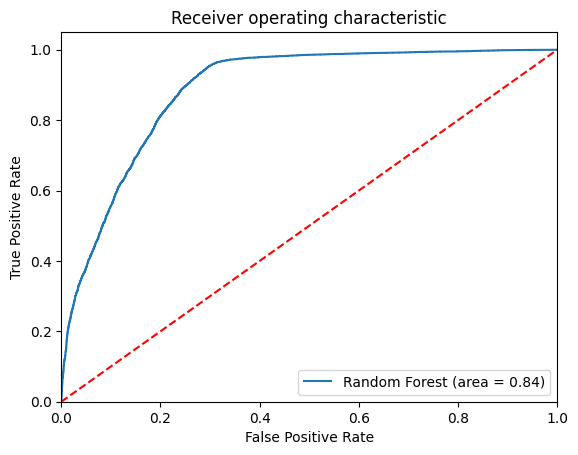

In [21]:
logit_roc_auc = roc_auc_score(y_test, y_pred)
fpr, tpr, thresholds = roc_curve(y_test, model.predict_proba(X_test)[:,1])
plt.figure()
plt.plot(fpr, tpr, label='Random Forest (area = %0.2f)' % logit_roc_auc)
plt.plot([0, 1], [0, 1],'r--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic')
plt.legend(loc="lower right")
plt.savefig('Log_ROC')
plt.show()

In [22]:
feature_imp = pd.Series(best_model.feature_importances_, index = X_train.columns).sort_values(ascending = False)
feature_imp

Dizziness                               0.077413
cv2_cc_Faint                            0.075151
cv2_cc_Normal Symptoms                  0.070421
Faint                                   0.067748
Consciousness                           0.062925
Paralysis                               0.061300
triage_Emergency symptoms               0.057533
cv2_cc_Consciousness                    0.038810
cv2_cc_Upper body Paralysis             0.038268
cv_cc_Heart, cerebrovascular            0.038198
cv_cc_Cerebralgia                       0.031313
age                                     0.030871
cv2_cc_strange pronunciation            0.028989
spo2_1                                  0.024596
sbp1                                    0.019943
bt1                                     0.019894
pr1                                     0.019529
diff_Temp_avg_day                       0.018801
Temperature                             0.018221
Temp_avg_month                          0.017833
diff_Temp_max_day   

In [ ]:
objective = 'binary'
boosting_type_range = ['gbdt', 'dart', 'goss']
max_depth_range = np.arange(1, 20, 2)
learning_rate_range = np.arange(0.001, 0.01, 0.001)

param_grid = {
    "boosting_type": boosting_type_range,
    "max_depth": max_depth_range,
    "learning_rate": learning_rate_range,
}

lgb_model = lgb.LGBMClassifier(objective=objective, num_leaves=31)  # Set base model objective

# Use RandomizedSearchCV with 5-fold cross-validation and 20 iterations
lgb_random = RandomizedSearchCV(estimator=lgb_model, param_distributions=param_grid, cv=5, n_iter=20)

lgb_random.fit(X_train, y_train)  # Fit the model with hyperparameter tuning

# Get the best model with optimal hyperparameters
best_model = lgb_random.best_estimator_

y_pred = best_model.predict(X_test)  # Make predictions on the test set

accuracy = accuracy_score(y_test, y_pred)
precision = precision_score(y_test, y_pred)
recall = recall_score(y_test, y_pred)
f1 = f1_score(y_test, y_pred)
auc = roc_auc_score(y_test, y_pred)

# Print or store the evaluation metrics
print("Accuracy:", accuracy)
print("Precision:", precision)
print("Recall:", recall)
print("F1-score:", f1)
print("AUC:", auc)
print(classification_report(y_test, y_pred))

In [ ]:
logit_roc_auc = roc_auc_score(y_test, y_pred)
fpr, tpr, thresholds = roc_curve(y_test, model.predict_proba(X_test)[:,1])
plt.figure()
plt.plot(fpr, tpr, label='Light GBM (area = %0.2f)' % logit_roc_auc)
plt.plot([0, 1], [0, 1],'r--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic')
plt.legend(loc="lower right")
plt.savefig('Log_ROC')
plt.show()

In [42]:
from sklearn.utils.class_weight import compute_class_weight
from xgboost import XGBClassifier
# Calculate class weights
class_weights = compute_class_weight('balanced', classes=[0, 1], y=y_train)
class_weight = class_weights[1]/class_weights[0]
booster_type_range = ['gbtree', 'gblinear', 'dart']
max_depth_range = np.arange(1, 25, 2)
max_leaves = 0

param_grid = {
    "booster": booster_type_range,
    "max_depth": max_depth_range,
}

# Create base XGBoost classifier with class weights
xgb_model = XGBClassifier(scale_pos_weight = class_weight)

# Use RandomizedSearchCV with 5-fold cross-validation and 20 iterations
xgb_random = RandomizedSearchCV(estimator=xgb_model, param_distributions=param_grid, cv=5, n_iter=20)

xgb_random.fit(X_train, y_train)  # Fit the model with hyperparameter tuning

# Get the best model with optimal hyperparameters
best_model = xgb_random.best_estimator_

y_pred = best_model.predict(X_test)  # Make predictions on the test set

accuracy = accuracy_score(y_test, y_pred)
precision = precision_score(y_test, y_pred)
recall = recall_score(y_test, y_pred)
f1 = f1_score(y_test, y_pred)
auc = roc_auc_score(y_test, y_pred)

# Print or store the evaluation metrics
print("Accuracy:", accuracy)
print("Precision:", precision)
print("Recall:", recall)
print("F1-score:", f1)
print("AUC:", auc)
print(classification_report(y_test, y_pred))

/usr/local/lib/python3.10/dist-packages/xgboost/core.py:160: UserWarning: [06:58:43] WARNING: /workspace/src/learner.cc:742: 
Parameters: { "max_depth" } are not used.

  warnings.warn(smsg, UserWarning)
/usr/local/lib/python3.10/dist-packages/xgboost/core.py:160: UserWarning: [06:58:44] WARNING: /workspace/src/learner.cc:742: 
Parameters: { "max_depth" } are not used.

  warnings.warn(smsg, UserWarning)
/usr/local/lib/python3.10/dist-packages/xgboost/core.py:160: UserWarning: [06:58:45] WARNING: /workspace/src/learner.cc:742: 
Parameters: { "max_depth" } are not used.

  warnings.warn(smsg, UserWarning)
/usr/local/lib/python3.10/dist-packages/xgboost/core.py:160: UserWarning: [06:58:46] WARNING: /workspace/src/learner.cc:742: 
Parameters: { "max_depth" } are not used.

  warnings.warn(smsg, UserWarning)
/usr/local/lib/python3.10/dist-packages/xgboost/core.py:160: UserWarning: [06:58:47] WARNING: /workspace/src/learner.cc:742: 
Parameters: { "max_depth" } are not used.

  warnings.warn

Accuracy: 0.8473525469168901
Precision: 0.8369555495930596
Recall: 0.911375146084924
F1-score: 0.8725814723297124
AUC: 0.8363187935767732
              precision    recall  f1-score   support

         0.0       0.86      0.76      0.81      7636
         1.0       0.84      0.91      0.87     10268

    accuracy                           0.85     17904
   macro avg       0.85      0.84      0.84     17904
weighted avg       0.85      0.85      0.85     17904



In [45]:
xgb_random.best_estimator_

XGBClassifier(base_score=None, booster='dart', callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, device=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, feature_types=None,
              gamma=None, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=None, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=5, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              multi_strategy=None, n_estimators=None, n_jobs=None,
              num_parallel_tree=None, random_state=None, ...)

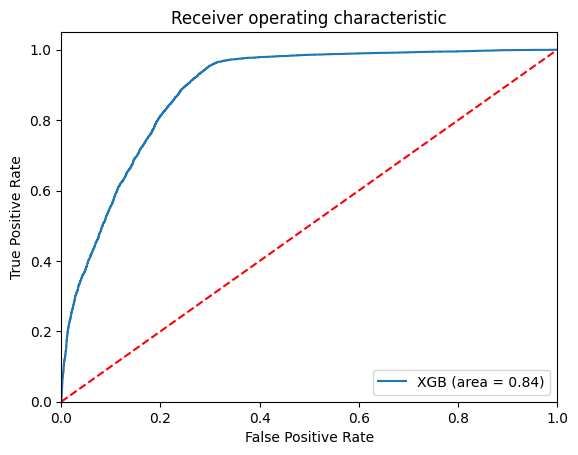

In [43]:
logit_roc_auc = roc_auc_score(y_test, y_pred)
fpr, tpr, thresholds = roc_curve(y_test, model.predict_proba(X_test)[:,1])
plt.figure()
plt.plot(fpr, tpr, label='XGB (area = %0.2f)' % logit_roc_auc)
plt.plot([0, 1], [0, 1],'r--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic')
plt.legend(loc="lower right")
plt.savefig('Log_ROC')
plt.show()

In [44]:
feature_imp = pd.Series(best_model.feature_importances_, index = X_train.columns).sort_values(ascending = False)
feature_imp

cv2_cc_Normal Symptoms                  0.380812
Faint                                   0.223205
cv2_cc_Faint                            0.189600
cv2_cc_Misc                             0.047945
Dizziness                               0.021156
triage_Emergency symptoms               0.019578
Paralysis                               0.017324
cv2_cc_strange pronunciation            0.013802
Consciousness                           0.010624
cv2_cc_Upper body Paralysis             0.009185
cv2_cc_Leg Paralysis                    0.008814
cv2_cc_Consciousness                    0.008187
triage_Potential emergency symptom      0.007519
hy_di_disease                           0.004464
stroke                                  0.003334
cv_cc_Cerebralgia                       0.002711
spo2_1                                  0.002500
cv2_cc_Leg Planting/paralysis (left)    0.001708
age                                     0.001699
cv2_act_After sleep                     0.001642
sbp1                

#Creating tree models Label feature encodings

In [22]:
# Create a label encoder
encoder = LabelEncoder()
feature_to_encode = ['cv_cc', 'cv2_cc', 'cv2_act', 'triage']
# Encode the specified features
for feature in feature_to_encode:
    model_data[feature] = encoder.fit_transform(model_data[feature])

In [23]:
X_2 = model_data.iloc[:,model_data.columns != 'cv2_cphss']
y_2 = model_data.cv2_cphss
X_train_2, X_test_2, y_train_2, y_test_2 = train_test_split(X_2, y_2, test_size=0.20, random_state=5)

In [ ]:
n_estimators_range = np.arange(100, 500, 25)
max_depth_range = np.arange(5, 25, 2)
max_features_range = ["sqrt", None, "log2"]

param_grid = {
    "n_estimators": n_estimators_range,
    "max_depth": max_depth_range,
    "max_features": max_features_range,
}

rf_model = RandomForestClassifier(class_weight='balanced', n_jobs=-1)  # Create the base model

# Use RandomizedSearchCV with 5-fold cross-validation and 20 iterations
rf_random = RandomizedSearchCV(estimator=rf_model, param_distributions=param_grid, cv=5, n_iter=20)

rf_random.fit(X_train_2, y_train_2)  # Fit the model with hyperparameter tuning

# Get the best model with optimal hyperparameters
best_model_rf_2 = rf_random.best_estimator_

y_pred = best_model_rf_2.predict(X_test_2)  # Make predictions on the test set

accuracy = accuracy_score(y_test_2, y_pred)
precision = precision_score(y_test_2, y_pred)
recall = recall_score(y_test_2, y_pred)
f1 = f1_score(y_test_2, y_pred)
auc = roc_auc_score(y_test_2, y_pred)

# Print or store the evaluation metrics
print("Accuracy:", accuracy)
print("Precision:", precision)
print("Recall:", recall)
print("F1-score:", f1)
print("AUC:", auc)
print(classification_report(y_test_2, y_pred))

In [ ]:
feature_imp = pd.Series(best_model_rf_2.feature_importances_, index = X_train_2.columns).sort_values(ascending = False)
feature_imp

In [ ]:
# Calculate class weights
class_weights = compute_class_weight('balanced', classes=[0, 1], y=y_train_2)
class_weight = class_weights[1]/class_weights[0]
booster_type_range = ['gbtree', 'gblinear', 'dart']
max_depth_range = np.arange(1, 25, 2)
max_leaves = 0

param_grid = {
    "booster": booster_type_range,
    "max_depth": max_depth_range,
}

# Create base XGBoost classifier with class weights
xgb_model = XGBClassifier(scale_pos_weight = class_weight)

# Use RandomizedSearchCV with 5-fold cross-validation and 20 iterations
xgb_random = RandomizedSearchCV(estimator=xgb_model, param_distributions=param_grid, cv=5, n_iter=20)

xgb_random.fit(X_train_2, y_train_2)  # Fit the model with hyperparameter tuning

# Get the best model with optimal hyperparameters
best_model_XGB_2 = xgb_random.best_estimator_

y_pred = best_model_XGB_2.predict(X_test_2)  # Make predictions on the test set

accuracy = accuracy_score(y_test_2, y_pred)
precision = precision_score(y_test_2, y_pred)
recall = recall_score(y_test_2, y_pred)
f1 = f1_score(y_test_2, y_pred)
auc = roc_auc_score(y_test_2, y_pred)

# Print or store the evaluation metrics
print("Accuracy:", accuracy)
print("Precision:", precision)
print("Recall:", recall)
print("F1-score:", f1)
print("AUC:", auc)
print(classification_report(y_test_2, y_pred))

In [ ]:
feature_imp = pd.Series(best_model_XGB_2.feature_importances_, index = X_train_2.columns).sort_values(ascending = False)
feature_imp

In [25]:
model = LogisticRegression()
model.fit(X_train_2, y_train_2)
y_pred = model.predict(X_test_2)

# metrics are used to find accuracy or error
train_acc = model.score(X_train_2, y_train_2)
print("The Accuracy for Training Set is {}".format(train_acc*100))

test_acc = accuracy_score(y_test_2, y_pred)
print("The Accuracy for Test Set is {}".format(test_acc*100))

print(classification_report(y_test_2, y_pred))

The Accuracy for Training Set is 80.36209553158706
The Accuracy for Test Set is 80.17257318952234
              precision    recall  f1-score   support

         0.0       0.80      0.72      0.76      6979
         1.0       0.80      0.86      0.83      9246

    accuracy                           0.80     16225
   macro avg       0.80      0.79      0.79     16225
weighted avg       0.80      0.80      0.80     16225



/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


In [26]:
import statsmodels.api as sm
logit_model=sm.Logit(y_train_2,X_train_2)
result=logit_model.fit()
print(result.summary())

Optimization terminated successfully.
         Current function value: 0.399810
         Iterations 7
                           Logit Regression Results                           
Dep. Variable:              cv2_cphss   No. Observations:                64900
Model:                          Logit   Df Residuals:                    64872
Method:                           MLE   Df Model:                           27
Date:                Mon, 26 Feb 2024   Pseudo R-squ.:                  0.4142
Time:                        01:31:16   Log-Likelihood:                -25948.
converged:                       True   LL-Null:                       -44292.
Covariance Type:            nonrobust   LLR p-value:                     0.000
                        coef    std err          z      P>|z|      [0.025      0.975]
-------------------------------------------------------------------------------------
cv_cc                -0.4708      0.045    -10.428      0.000      -0.559      -0.382
cv2_cc  

In [27]:
significant_features = ['cv_cc','cv2_cc','cv2_act','stroke','triage','onset','age','dbp1','sbp1','pr1','rr1','bt1','spo2_1','Spasm','Dizziness','Faint',
                        'Consciousness','Paralysis','hy_di_disease']
                        #,'diff_Temp_min_day']

X_train_significant = X_train_2[significant_features]
X_test_significant = X_test_2[significant_features]

In [28]:
logit_model=sm.Logit(y_train_2,X_train_significant)
result=logit_model.fit()
print(result.summary())

Optimization terminated successfully.
         Current function value: 0.399969
         Iterations 7
                           Logit Regression Results                           
Dep. Variable:              cv2_cphss   No. Observations:                64900
Model:                          Logit   Df Residuals:                    64881
Method:                           MLE   Df Model:                           18
Date:                Mon, 26 Feb 2024   Pseudo R-squ.:                  0.4139
Time:                        01:31:48   Log-Likelihood:                -25958.
converged:                       True   LL-Null:                       -44292.
Covariance Type:            nonrobust   LLR p-value:                     0.000
                    coef    std err          z      P>|z|      [0.025      0.975]
---------------------------------------------------------------------------------
cv_cc            -0.4709      0.045    -10.460      0.000      -0.559      -0.383
cv2_cc            0.

In [29]:
model = LogisticRegression(max_iter=10000)
model.fit(X_train_significant, y_train_2)
y_pred = model.predict(X_test_significant)

# metrics are used to find accuracy or error
train_acc = model.score(X_train_significant, y_train_2)
print("The Accuracy for Training Set is {}".format(train_acc*100))

test_acc = accuracy_score(y_test_2, y_pred)
print("The Accuracy for Test Set is {}".format(test_acc*100))

print(classification_report(y_test_2, y_pred))

The Accuracy for Training Set is 83.21417565485362
The Accuracy for Test Set is 83.18027734976887
              precision    recall  f1-score   support

         0.0       0.87      0.71      0.78      6979
         1.0       0.81      0.92      0.86      9246

    accuracy                           0.83     16225
   macro avg       0.84      0.82      0.82     16225
weighted avg       0.84      0.83      0.83     16225



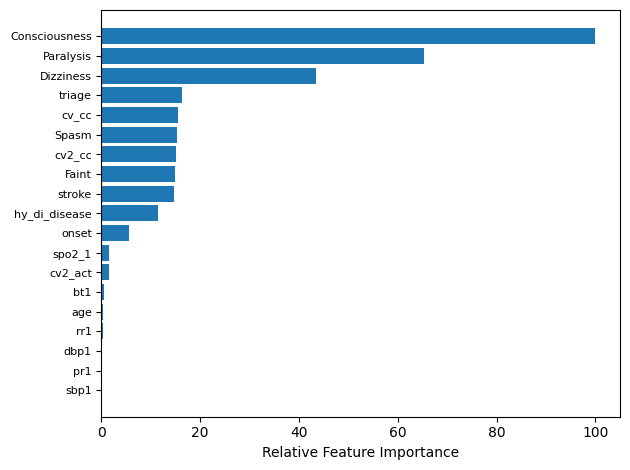

In [30]:
import matplotlib.pyplot as plt

feature_importance = abs(model.coef_[0])
feature_importance = 100.0 * (feature_importance / feature_importance.max())
sorted_idx = np.argsort(feature_importance)
pos = np.arange(sorted_idx.shape[0]) + .5

featfig = plt.figure()
featax = featfig.add_subplot(1, 1, 1)
featax.barh(pos, feature_importance[sorted_idx], align='center')
featax.set_yticks(pos)
featax.set_yticklabels(np.array(X_train_significant.columns)[sorted_idx], fontsize=8)
featax.set_xlabel('Relative Feature Importance')

plt.tight_layout()
plt.show()

In [31]:
# Extract feature names and absolute importance values
feature_names = np.array(X_train_significant.columns)
absolute_importance = abs(model.coef_[0])

# Sort features and importance values together by importance
sorted_indices = np.argsort(absolute_importance)[::-1]  # Descending order
sorted_features = feature_names[sorted_indices]
sorted_importance = absolute_importance[sorted_indices]

# Create a pandas DataFrame
importance_df = pd.DataFrame({'Feature': sorted_features, 'Absolute Coefficient': sorted_importance})

# Display the DataFrame
print(importance_df)

          Feature  Absolute Coefficient
0   Consciousness              3.005808
1       Paralysis              1.962410
2       Dizziness              1.305967
3          triage              0.489388
4           cv_cc              0.467170
5           Spasm              0.458401
6          cv2_cc              0.452523
7           Faint              0.446369
8          stroke              0.442107
9   hy_di_disease              0.341621
10          onset              0.168343
11         spo2_1              0.043034
12        cv2_act              0.042779
13            bt1              0.018314
14            age              0.009686
15            rr1              0.008437
16           dbp1              0.004716
17            pr1              0.002616
18           sbp1              0.001369


In [32]:
# Create a Random Forest classifier
rf_model = RandomForestClassifier(class_weight='balanced', max_depth=18, n_estimators=400,
                       n_jobs=-1, random_state=42)  # Adjust hyperparameters as needed

# Fit the model to the training data
rf_model.fit(X_train_significant, y_train_2)

# Make predictions on the test data
y_pred_rf = rf_model.predict(X_test_significant)

# Calculate and print accuracy metrics
train_acc_rf = rf_model.score(X_train_significant, y_train_2)
print("Random Forest - Training Accuracy: {}".format(train_acc_rf * 100))

test_acc_rf = accuracy_score(y_test_2, y_pred_rf)
print("Random Forest - Test Accuracy: {}".format(test_acc_rf * 100))

print(classification_report(y_test_2, y_pred_rf))

Random Forest - Training Accuracy: 92.5346687211094
Random Forest - Test Accuracy: 85.12172573189522
              precision    recall  f1-score   support

         0.0       0.89      0.75      0.81      6979
         1.0       0.83      0.93      0.88      9246

    accuracy                           0.85     16225
   macro avg       0.86      0.84      0.84     16225
weighted avg       0.86      0.85      0.85     16225



In [33]:
feature_imp = pd.Series(rf_model.feature_importances_, index = X_train_significant.columns).sort_values(ascending = False)
feature_imp

cv2_cc           0.167646
Faint            0.098334
Consciousness    0.095440
Dizziness        0.092213
Paralysis        0.079116
triage           0.078521
age              0.059002
cv_cc            0.049846
pr1              0.046241
bt1              0.042973
spo2_1           0.042402
sbp1             0.041991
dbp1             0.035278
rr1              0.029837
cv2_act          0.012458
onset            0.007919
stroke           0.007661
hy_di_disease    0.007621
Spasm            0.005501
dtype: float64

In [37]:
# Create an XGBoost classifier
xgb_model = XGBClassifier(scale_pos_weight=1.2, n_estimators=100, random_state=42)  # Adjust hyperparameters as needed

# Fit the model to the training data
xgb_model.fit(X_train_significant, y_train_2)

# Make predictions on the test data
y_pred_xgb = xgb_model.predict(X_test_significant)

# Calculate and print accuracy metrics
train_acc_xgb = xgb_model.score(X_train_significant, y_train_2)
print("XGBoost - Training Accuracy: {}".format(train_acc_xgb * 100))

test_acc_xgb = accuracy_score(y_test_2, y_pred_xgb)
print("XGBoost - Test Accuracy: {}".format(test_acc_xgb * 100))

print(classification_report(y_test_2, y_pred_xgb))

XGBoost - Training Accuracy: 86.75963020030817
XGBoost - Test Accuracy: 84.788906009245
              precision    recall  f1-score   support

         0.0       0.90      0.73      0.80      6979
         1.0       0.82      0.94      0.88      9246

    accuracy                           0.85     16225
   macro avg       0.86      0.83      0.84     16225
weighted avg       0.85      0.85      0.84     16225



In [38]:
feature_imp = pd.Series(xgb_model.feature_importances_, index = X_train_significant.columns).sort_values(ascending = False)
feature_imp

Faint            0.615130
Dizziness        0.214187
cv2_cc           0.041160
Paralysis        0.035676
Consciousness    0.023441
triage           0.022777
hy_di_disease    0.007264
stroke           0.006387
cv_cc            0.004384
spo2_1           0.003984
Spasm            0.003835
age              0.003201
cv2_act          0.002975
sbp1             0.002872
bt1              0.002705
dbp1             0.002693
onset            0.002550
pr1              0.002446
rr1              0.002334
dtype: float32

### Experiments without Binary Feature variables

In [39]:
features_without_binary_symptoms = ['cv_cc','cv2_cc','cv2_act','stroke','triage','onset','age','dbp1','sbp1','pr1','rr1','bt1',
                                    'spo2_1','hy_di_disease']
                                    #,'diff_Temp_min_day']

X_train_no_symptoms = X_train_2[features_without_binary_symptoms]
X_test_no_symptoms = X_test_2[features_without_binary_symptoms]

In [40]:
logit_model=sm.Logit(y_train_2,X_train_no_symptoms)
result=logit_model.fit()
print(result.summary())

Optimization terminated successfully.
         Current function value: 0.515095
         Iterations 6
                           Logit Regression Results                           
Dep. Variable:              cv2_cphss   No. Observations:                64900
Model:                          Logit   Df Residuals:                    64886
Method:                           MLE   Df Model:                           13
Date:                Mon, 26 Feb 2024   Pseudo R-squ.:                  0.2453
Time:                        01:34:20   Log-Likelihood:                -33430.
converged:                       True   LL-Null:                       -44292.
Covariance Type:            nonrobust   LLR p-value:                     0.000
                    coef    std err          z      P>|z|      [0.025      0.975]
---------------------------------------------------------------------------------
cv_cc            -2.0169      0.027    -75.641      0.000      -2.069      -1.965
cv2_cc           -0.

In [41]:
model = LogisticRegression(max_iter=10000)
model.fit(X_train_no_symptoms, y_train_2)
y_pred = model.predict(X_test_no_symptoms)

# metrics are used to find accuracy or error
train_acc = model.score(X_train_no_symptoms, y_train_2)
print("The Accuracy for Training Set is {}".format(train_acc*100))

test_acc = accuracy_score(y_test_2, y_pred)
print("The Accuracy for Test Set is {}".format(test_acc*100))

print(classification_report(y_test_2, y_pred))

The Accuracy for Training Set is 74.82126348228043
The Accuracy for Test Set is 75.1864406779661
              precision    recall  f1-score   support

         0.0       0.75      0.63      0.69      6979
         1.0       0.75      0.85      0.80      9246

    accuracy                           0.75     16225
   macro avg       0.75      0.74      0.74     16225
weighted avg       0.75      0.75      0.75     16225



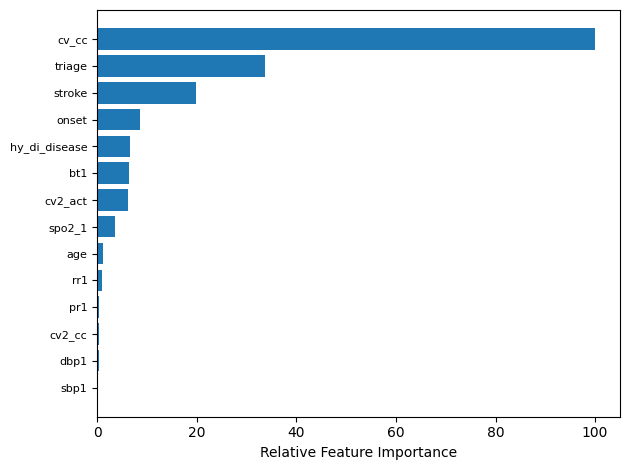

In [42]:
feature_importance = abs(model.coef_[0])
feature_importance = 100.0 * (feature_importance / feature_importance.max())
sorted_idx = np.argsort(feature_importance)
pos = np.arange(sorted_idx.shape[0]) + .5

featfig = plt.figure()
featax = featfig.add_subplot(1, 1, 1)
featax.barh(pos, feature_importance[sorted_idx], align='center')
featax.set_yticks(pos)
featax.set_yticklabels(np.array(X_train_no_symptoms.columns)[sorted_idx], fontsize=8)
featax.set_xlabel('Relative Feature Importance')

plt.tight_layout()
plt.show()

In [43]:
# Extract feature names and absolute importance values
feature_names = np.array(X_train_no_symptoms.columns)
absolute_importance = abs(model.coef_[0])

# Sort features and importance values together by importance
sorted_indices = np.argsort(absolute_importance)[::-1]  # Descending order
sorted_features = feature_names[sorted_indices]
sorted_importance = absolute_importance[sorted_indices]

# Create a pandas DataFrame
importance_df = pd.DataFrame({'Feature': sorted_features, 'Absolute Coefficient': sorted_importance})

# Display the DataFrame
print(importance_df)

          Feature  Absolute Coefficient
0           cv_cc              2.006053
1          triage              0.676294
2          stroke              0.399189
3           onset              0.172765
4   hy_di_disease              0.131450
5             bt1              0.128469
6         cv2_act              0.123419
7          spo2_1              0.069361
8             age              0.022686
9             rr1              0.020266
10            pr1              0.006101
11         cv2_cc              0.005743
12           dbp1              0.005283
13           sbp1              0.001549


In [44]:
# Create a Random Forest classifier
rf_model = RandomForestClassifier(class_weight='balanced', max_depth=17, n_estimators=400,
                       n_jobs=-1 , random_state=42)  # Adjust hyperparameters as needed

# Fit the model to the training data
rf_model.fit(X_train_no_symptoms, y_train_2)

# Make predictions on the test data
y_pred_rf = rf_model.predict(X_test_no_symptoms)

# Calculate and print accuracy metrics
train_acc_rf = rf_model.score(X_train_no_symptoms, y_train_2)
print("Random Forest - Training Accuracy: {}".format(train_acc_rf * 100))

test_acc_rf = accuracy_score(y_test_2, y_pred_rf)
print("Random Forest - Test Accuracy: {}".format(test_acc_rf * 100))

print(classification_report(y_test_2, y_pred_rf))

Random Forest - Training Accuracy: 92.10477657935286
Random Forest - Test Accuracy: 83.99383667180277
              precision    recall  f1-score   support

         0.0       0.86      0.75      0.80      6979
         1.0       0.83      0.90      0.87      9246

    accuracy                           0.84     16225
   macro avg       0.84      0.83      0.83     16225
weighted avg       0.84      0.84      0.84     16225



In [45]:
feature_imp = pd.Series(rf_model.feature_importances_, index = X_train_no_symptoms.columns).sort_values(ascending = False)
feature_imp

cv2_cc           0.338344
triage           0.120764
cv_cc            0.105278
age              0.081979
spo2_1           0.068074
pr1              0.055753
bt1              0.052155
sbp1             0.051944
dbp1             0.043575
rr1              0.037173
cv2_act          0.017611
stroke           0.009860
onset            0.009240
hy_di_disease    0.008250
dtype: float64

In [46]:
# Create an XGBoost classifier
xgb_model = XGBClassifier(scale_pos_weight=1.2, n_estimators=100, random_state=42)  # Adjust hyperparameters as needed

# Fit the model to the training data
xgb_model.fit(X_train_no_symptoms, y_train_2)

# Make predictions on the test data
y_pred_xgb = xgb_model.predict(X_test_no_symptoms)

# Calculate and print accuracy metrics
train_acc_xgb = xgb_model.score(X_train_no_symptoms, y_train_2)
print("XGBoost - Training Accuracy: {}".format(train_acc_xgb * 100))

test_acc_xgb = accuracy_score(y_test_2, y_pred_xgb)
print("XGBoost - Test Accuracy: {}".format(test_acc_xgb * 100))

print(classification_report(y_test_2, y_pred_xgb))

XGBoost - Training Accuracy: 85.84283513097073
XGBoost - Test Accuracy: 84.19722650231125
              precision    recall  f1-score   support

         0.0       0.88      0.73      0.80      6979
         1.0       0.82      0.93      0.87      9246

    accuracy                           0.84     16225
   macro avg       0.85      0.83      0.83     16225
weighted avg       0.85      0.84      0.84     16225



In [47]:
feature_imp = pd.Series(xgb_model.feature_importances_, index = X_train_no_symptoms.columns).sort_values(ascending = False)
feature_imp

triage           0.386123
cv2_cc           0.294202
cv_cc            0.201773
stroke           0.021420
hy_di_disease    0.021250
spo2_1           0.013074
age              0.008948
cv2_act          0.008345
sbp1             0.008162
bt1              0.007945
dbp1             0.007870
onset            0.007572
rr1              0.006707
pr1              0.006609
dtype: float32